In [1]:
from transformers import ViTImageProcessor
from utils import download_imagenet_labels, overlay, overlay2, plot_auc_line
import time
from PIL import Image
from GradMask import GradMask

2025-04-22 16:18:11.267815: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 16:18:11.276765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745331491.287879  729979 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745331491.291410  729979 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 16:18:11.303210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Parameters

In [2]:
# Image processor for ViT model (only used for resizing image during the plot)
resizer = ViTImageProcessor(do_rescale=False, do_normalize=False)

# URL to download ImageNet labels
imagenet_labels_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_labels = download_imagenet_labels(imagenet_labels_url)
class_labels_lower = [cls.lower() for cls in class_labels]
imagenet_label_dict = {index: label for index, label in enumerate(class_labels)}

In [3]:
masks_layers = 4

# ViT

In [4]:
# Initialize MUTEX model for ViT
model_vit = GradMask('vit', 'cpu')

## Single Image Plot

`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


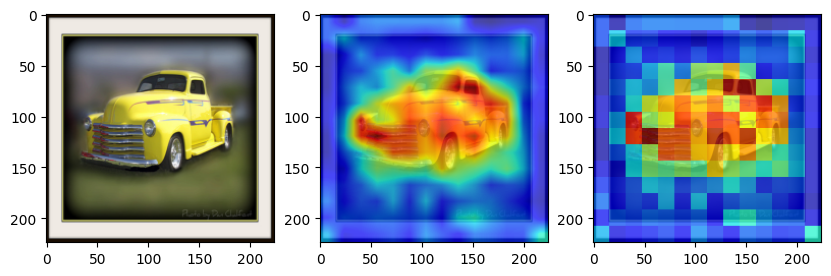

In [5]:
img_path = '../Example_images/pickup.jpg'

# Open the image using PIL
image = Image.open(img_path).convert('RGB')

# Resize and preprocess the image for the model
img = resizer(image, return_tensors="pt")['pixel_values'][0]

saliency, label = model_vit.get_saliency(img_path, masks_layers)

# Display overlay of image and saliency map
overlay(img, saliency)

## Multi image plot with AUC

In [6]:
img_paths = [
            '../Example_images/ski.jpg',
            '../Example_images/spoonbill.jpg',
            '../Example_images/pickup.jpg',
            ]

# Percentage of patches for insertion and deletion metrics
patch_perc = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Baseline for insertion and deletion calculation
baseline = 'black'

Time taken: 4.142703294754028


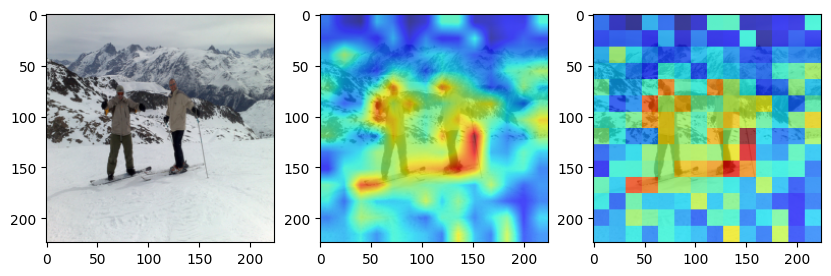

Time taken: 4.025336742401123


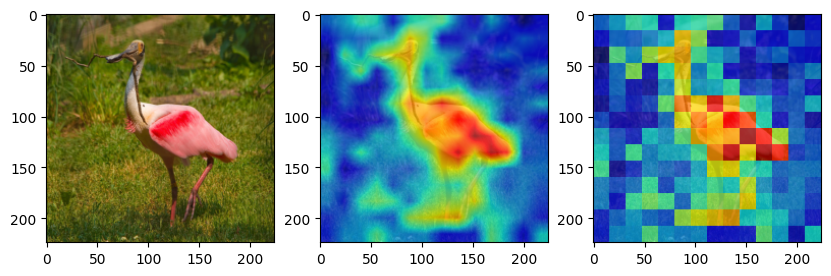

Time taken: 3.8658759593963623


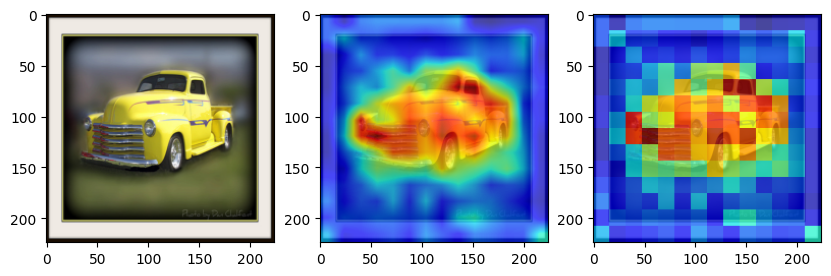

In [11]:
# Lists to store metrics, images, and labels
metrics_list = []
images_list = []
label_list = []
saliency_list = []

# Loop over each image path
for i in range(len(img_paths)):
    img_path = img_paths[i]
    start_time = time.time()

    # Get saliency map and label using MLEx model
    saliency, label = model_vit.get_saliency(img_path, masks_layers)
    print(f'Time taken: {time.time() - start_time}')

    # Open the image using PIL
    image = Image.open(img_path).convert('RGB')

    # Resize and preprocess the image for the model
    img = resizer(image, return_tensors="pt")['pixel_values'][0]

    # Display overlay of image and saliency map
    overlay(img, saliency)

    # Get insertion and deletion metrics
    metrics = model_vit.get_insertion_deletion(patch_perc, saliency, image, baseline, label)

    # Append metrics, image, and label to respective lists
    metrics_list.append(metrics)
    images_list.append(img)
    label_list.append(imagenet_label_dict[label + 1])
    saliency_list.append(saliency)

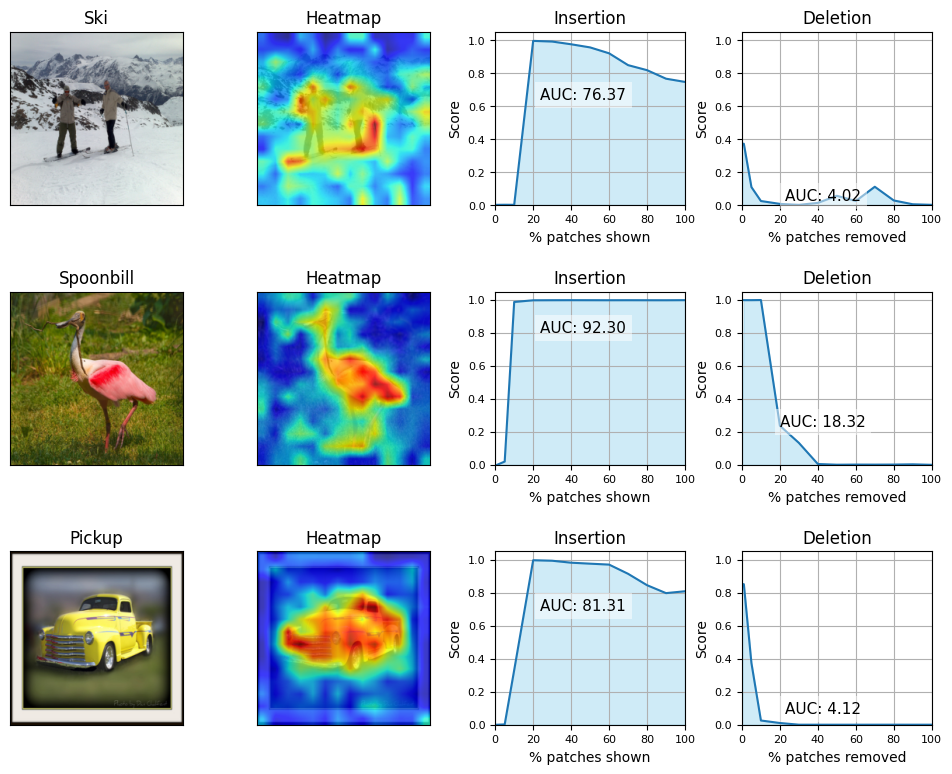

In [12]:
# Plot AUC curves for insertion and deletion metrics
plot_auc_line(metrics_list, patch_perc, images_list, label_list, saliency_list, title = 'AUC_ViT', figsize_x = 12, figsize_y = 3, alpha = 0.75)

## Multi class image

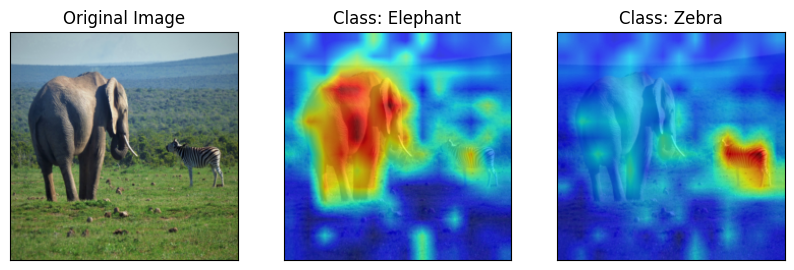

<Figure size 640x480 with 0 Axes>

In [13]:
img_path = '../Example_images/elefante-zebra.jpg'

# Open the image using PIL
image = Image.open(img_path).convert('RGB')

# Resize and preprocess the image for the model
img = resizer(image, return_tensors="pt")['pixel_values'][0]

saliency1, _ = model_vit.get_saliency(img_path, masks_layers, 385)
saliency2, _ = model_vit.get_saliency(img_path, masks_layers, 340)

# Display overlay of image and saliency map
overlay2(img, saliency1, saliency2, title = 'ViT_multiclass')

# DeiT

In [14]:
# Initialize MUTEX model for DeiT
model_deit = GradMask('deit', 'cpu')

## Single Image Plot

`DeiTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


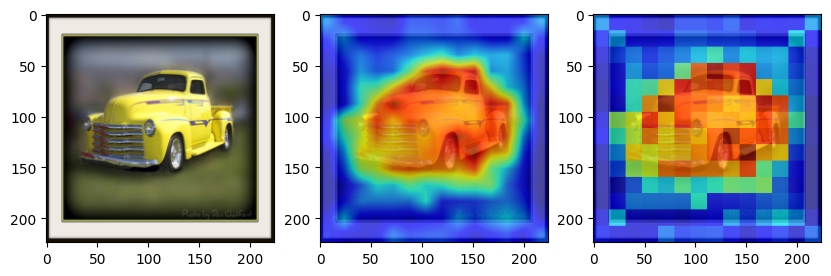

In [15]:
img_path = '../Example_images/pickup.jpg'

# Open the image using PIL
image = Image.open(img_path).convert('RGB')

# Resize and preprocess the image for the model
img = resizer(image, return_tensors="pt")['pixel_values'][0]

saliency, label = model_deit.get_saliency(img_path, masks_layers)

# Display overlay of image and saliency map
overlay(img, saliency)

## Multi image plot with AUC

In [16]:
# Percentage of patches for insertion and deletion metrics
patch_perc = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Baseline for insertion and deletion calculation
baseline = 'black'

Time taken: 3.9889492988586426


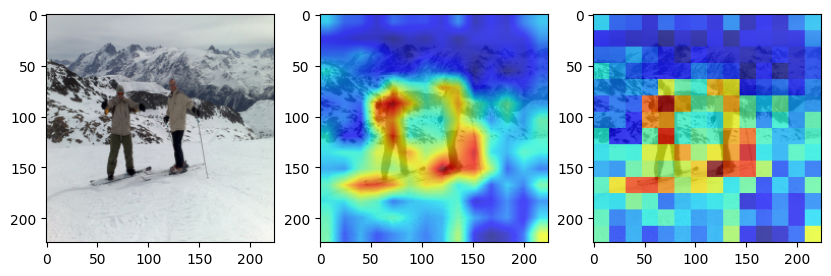

Time taken: 4.024730920791626


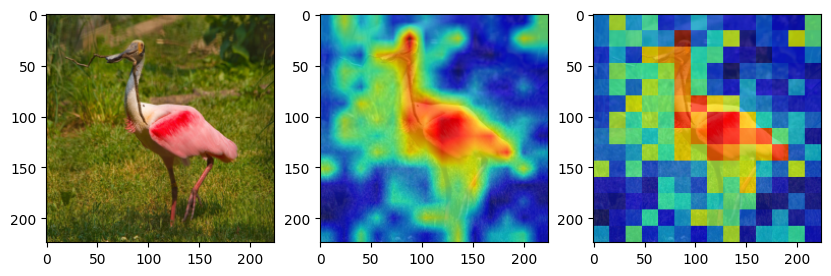

Time taken: 4.026053428649902


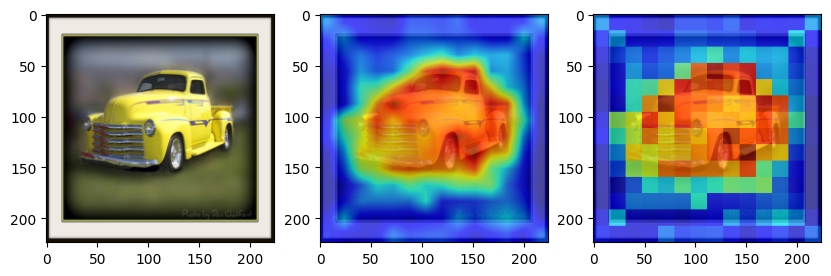

In [17]:
# Lists to store metrics, images, and labels
metrics_list = []
images_list = []
label_list = []
saliency_list = []

# Loop over each image path
for i in range(len(img_paths)):
    img_path = img_paths[i]
    start_time = time.time()

    # Get saliency map and label using MLEx model
    saliency, label = model_deit.get_saliency(img_path, masks_layers)
    print(f'Time taken: {time.time() - start_time}')

    # Open the image using PIL
    image = Image.open(img_path).convert('RGB')

    # Resize and preprocess the image for the model
    img = resizer(image, return_tensors="pt")['pixel_values'][0]

    # Display overlay of image and saliency map
    overlay(img, saliency)

    # Get insertion and deletion metrics
    metrics = model_deit.get_insertion_deletion(patch_perc, saliency, image, baseline, label)

    # Append metrics, image, and label to respective lists
    metrics_list.append(metrics)
    images_list.append(img)
    label_list.append(imagenet_label_dict[label + 1])
    saliency_list.append(saliency)

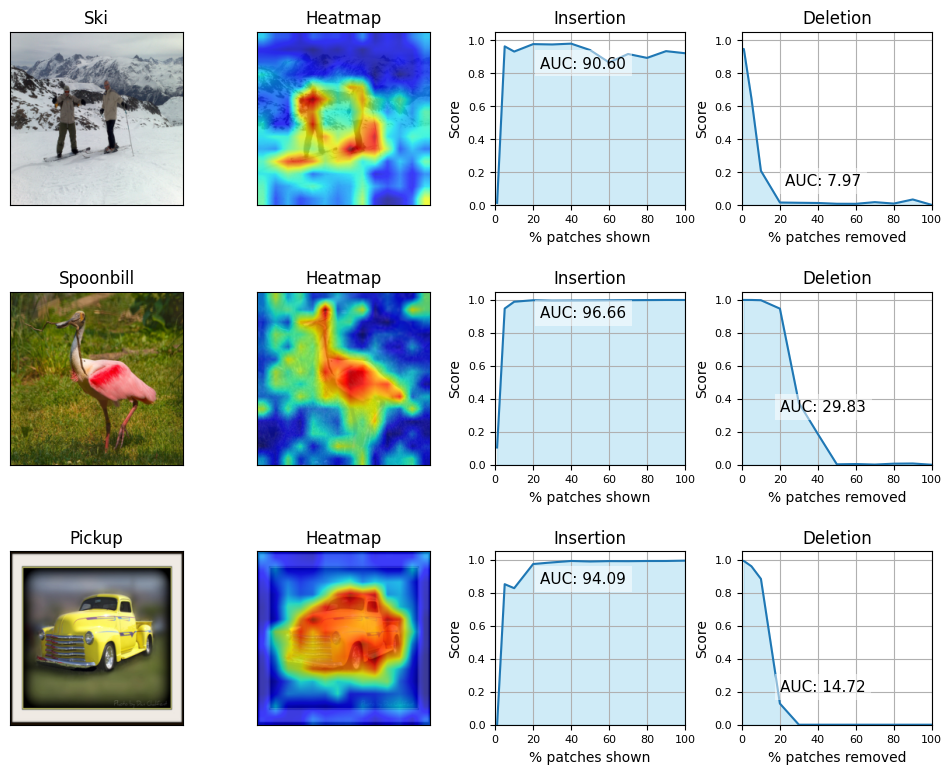

In [18]:
# Plot AUC curves for insertion and deletion metrics
plot_auc_line(metrics_list, patch_perc, images_list, label_list, saliency_list, title = 'AUC_DeiT', figsize_x = 12, figsize_y = 3, alpha = 0.75)

## Multi class image

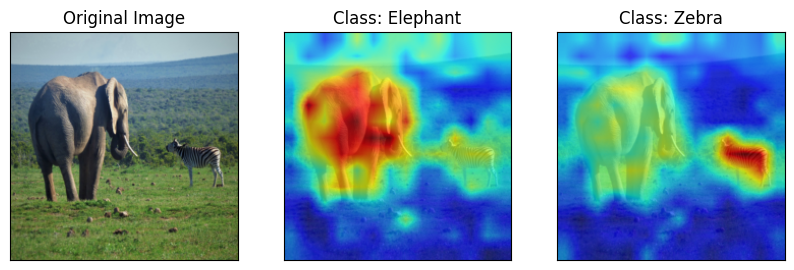

<Figure size 640x480 with 0 Axes>

In [19]:
img_path = '../Example_images/elefante-zebra.jpg'

# Open the image using PIL
image = Image.open(img_path).convert('RGB')

# Resize and preprocess the image for the model
img = resizer(image, return_tensors="pt")['pixel_values'][0]

saliency1, _ = model_deit.get_saliency(img_path, masks_layers, 385)
saliency2, _ = model_deit.get_saliency(img_path, masks_layers, 340)

# Display overlay of image and saliency map
overlay2(img, saliency1, saliency2, title = 'DeiT_multiclass')